In [276]:
import gc
import cv2
import torch
import numpy as np
import ultralytics
import matplotlib.pyplot as plt

import uuid
import datetime

from sklearn.preprocessing import MinMaxScaler
from skimage.metrics import structural_similarity
from transformers import DPTImageProcessor, DPTForDepthEstimation

In [277]:
imgs = [
    cv2.imread("/home/akiirabino/video-anal/ipynb/dataset-1/train/images/snapshot 12 èáßßá-02_12_23_10_11_19.png"),
    cv2.imread("/home/akiirabino/video-anal/ipynb/dataset-1/train/images/snapshot 12 èáßßá-02_12_23_12_05_10.png")
]

for i in range(len(imgs)):
    imgs[i] = cv2.resize(imgs[i], (640,640))

In [278]:
def detect(img):
    model = ultralytics.YOLO("/home/akiirabino/video-anal/ipynb/model/yolov8l-d3-e100-default-best.pt")
    result = model(img)
    del model
    torch.cuda.empty_cache()
    gc.collect()
    yolo_response = {
        "normalized_bboxes": [],
        "classes": [],
        "image_from_yolo": []
    }

    yolo_response["normalized_bboxes"] = result[0].boxes.xywhn
    yolo_response["classes"] = result[0].boxes.cls
    yolo_response["image_from_yolo"] = result[0].plot()

    return yolo_response

In [279]:
def yolo_detector_mock(data, frame_raw, uuid_camera):
    data["frame_raw"] = frame_raw
    result = detect(frame_raw)
    boxes =  result['normalized_bboxes']
    classes  = result['classes']
    image_from_yolo  = result['image_from_yolo']

    metadata = data.get("metadata", {})

    if boxes is None:
        print("No detections")
    else:
        # # labels ={'0': 'person', '1': 'customer', '2': 'seller'}
        # labels = result['names']
        # colors = {0: (0, 0, 255), 1: (0, 255, 0), 2: (255, 0, 0)}
        # height, width = frame_resize.shape[:2]
        # # отрисовка боксов на оригинальном изображении
        # for i, box in enumerate(boxes):
        #     # Рассчитываем координаты углов из центра и размеров
        #     x1, y1, x2, y2 = box[:4] * np.array([width, height, width, height])
        #     cv2.rectangle(frame_resize, (x1, y1), (x2, y2), colors[classes[i][0]], 2)
        # cv2.imshow(f'{windows_name} {uuid_camera}', frame_resize)

        # Отрисовка кадра полученного а рэя
        # data["frame_raw"] = image_from_yolo
        data["frame_show"] = image_from_yolo

        peoples = []

        for cl, n_bbox in zip(classes, boxes):
            x, y, w, h = list(map(int, map(lambda x: x*640, n_bbox)))
            peoples.append(
                {
                    "uuid": str(uuid.uuid4()),
                    "type": "",
                    "embedding": None,
                    "corner_coordinates": {
                        "x1": 0,
                        "x2": 0,
                        "y1": 0,
                        "y2": 0,
                    },
                    "center_point": [],
                    "distances": [],
                    "time_create": datetime.datetime.now(),
                    "normalized_bbox": n_bbox
                }
            )
            
            peoples[-1]["corner_coordinates"]["x1"] = int(x - w // 2)
            peoples[-1]["corner_coordinates"]["x2"] = int(x + w // 2)
            peoples[-1]["corner_coordinates"]["y1"] = int(y - h // 2)
            peoples[-1]["corner_coordinates"]["y2"] = int(y + h // 2)

            if cl == 1: peoples[-1]["type"] = "customer"
            elif cl == 2: peoples[-1]["type"] = "seller"
            else: peoples[-1]["type"] = "people"

            peoples[-1]["embedding"] = frame_raw[
                            peoples[-1]["corner_coordinates"]["y1"]:peoples[-1]["corner_coordinates"]["y2"],
                            peoples[-1]["corner_coordinates"]["x1"]:peoples[-1]["corner_coordinates"]["x2"],
                        ]
            

            metadata["peoples"] = peoples

        data['metadata'] = metadata
        data['to_kafka'] = {"event": "customer", "uuid_camera": uuid_camera}



    cv2.waitKey(1)

    return data

In [280]:
def intel_dpt_large_mock(data, name, imgsz, device, model_name):
    print(f"{name} depth estimation")

    processor = DPTImageProcessor.from_pretrained(model_name, cache_dir="models")
    model = DPTForDepthEstimation.from_pretrained(model_name, cache_dir="models")
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    model.to(device)

    scaler = MinMaxScaler((0, imgsz[0]))

    frame_raw = data.get("frame_raw")
    uuid_camera = data.get("uuid_camera")

    frame_resize = cv2.resize(frame_raw, imgsz)

    #Преобразование картинки во входные тензоры нейронки
    input = processor(frame_resize, return_tensors="pt").to(device)

    #Работает нейронка
    with torch.no_grad():
        outputs = model(**input)
        predicted_depth = outputs.predicted_depth

    #Переводим предикты из размеров нейронки в наши
    prediction = torch.nn.functional.interpolate(
        predicted_depth.unsqueeze(1),
        size=imgsz,
        mode="bicubic",
        align_corners=False,
    )

    #Достаем выход нейронки
    output = prediction.squeeze().cpu().numpy()
    output = scaler.fit_transform(output)

    # метаданные которые подгружаются в пайплайне
    metadata = data.get("metadata", {})
    metadata['frame_dpt'] = output

    # данные уходят дальше по пайплайну, и если нужно, будут сохранены комонентой SaveMetadataComponent
    data['metadata'] = metadata

    return data

In [281]:
def calculate_distance_mock(name, data):

    print(f"{name} distance calculate")

    uuid_camera = data.get("uuid_camera")
    metadata = data.get("metadata", {})
    peoples = metadata.get("peoples")

    
    if not peoples is None:
        frame_dpt = metadata["frame_dpt"]

        for people in peoples:
            x, y = list(map(lambda x: int(x*640), people["normalized_bbox"][:2]))
            dpt = int(frame_dpt[x-1:x, y-1:y].item())
            people["center_point"] = [x, y, dpt]


        for seller in [p for p in peoples if p["type"] == "seller"]:
            for customer in [p for p in peoples if p["type"] == "customer"]:                        
                distance = _distance(customer["center_point"], seller["center_point"])
                seller["distances"].append(
                    {
                        "uuid": customer["uuid"],
                        "distance": distance,
                    }
                )

                customer["distances"].append(
                    {
                        "uuid": seller["uuid"],
                        "distance": distance,
                    }
                )

        metadata["peoples"] = peoples

        # данные уходят дальше по пайплайну, и если нужно, будут сохранены комонентой SaveMetadataComponent
        data['metadata'] = metadata

        # пакет для отсылки результатов в кафку
        data['to_kafka'] = {
            "event": "customer",
            "uuid_camera":uuid_camera
        }

    return data

def _distance(xyz1, xyz2):
    x1, y1, z1 = xyz1
    x2, y2, z2 = xyz2
    return (
        np.sqrt(
            np.power(x1 - x2, 2) +
            np.power(y1 - y2, 2) +
            np.power(z1 - z2, 2)
        )
    )

In [282]:
def structural_similarity_mock(name, data):

    print(f"{name} structural similarity")

    uuid_camera = data.get("uuid_camera")
    metadata = data.get("metadata", {})
    peoples = metadata.get("peoples")
    prev_peoples = metadata.get("prev_peoples")

    similarity = []
    if not (peoples is None) and not (prev_peoples is None):
        for people in peoples:
            for prev_people in prev_peoples:
                emb_people = people["embedding"]
                emb_prev_people = cv2.resize(
                    prev_people["embedding"],
                    (emb_people.shape[1],
                    emb_people.shape[0])
                )

                similarity.append(
                    {
                        "uuid_people": people["uuid"],
                        "uuid_prev_people": prev_people["uuid"],
                        "value": structural_similarity(
                            emb_people,
                            emb_prev_people,
                            channel_axis=2
                        )
                    }
                )

        metadata["similarity"] = similarity
        data["metadata"] = metadata

        return data
    
    return data

In [283]:
def solo_customer_mock(
    name,
    data,
    threshold_similarity,
    threshold_time,
    threshold_distance
):

    print(f"{name} solo customer")
    metadata = data.get("metadata", {})
    solo_customers = metadata.get("solo_customers")
    similarity = metadata.get("similarity")
    peoples = metadata.get("peoples")


    if similarity is None or peoples is None:
        return data

    similarity_filtering = [sim for sim in similarity if sim["value"] > threshold_similarity]
    prev_peoples = metadata["prev_peoples"]

    peoples_min_distance = _min_distance(peoples)
    prev_peoples_min_distance = _min_distance(prev_peoples)

    peoples_distances = _filter_distance(peoples_min_distance, threshold_distance)
    prev_peoples_distances = _filter_distance(prev_peoples_min_distance, threshold_distance)

    uuid_sim = {sim["uuid_people"]:sim["uuid_prev_people"] for sim in similarity_filtering}
    
    if solo_customers is None:
        solo_customers = {}
        for key in peoples_distances.keys():
            if (
                    key in uuid_sim.keys() and
                    uuid_sim[key] in prev_peoples_distances.keys()
                ):
                solo_customers[key] = get_time_create(prev_peoples, uuid_sim[key])

        metadata["solo_customers"] = solo_customers
        data["metadata"] = metadata
        return data
    
    result = {}

    for key in solo_customers.keys():
        if key in uuid_sim.values():
            uuid_people = [value for value in uuid_sim.values() if value == key].pop()
            result[uuid_people] = solo_customers[key]
        else:
            solo_customers.pop(key)

    solo_customers = result

    current_time = datetime.datetime.now()

    loneliness = [
        key for key, value in solo_customers.items()
        if (current_time - value).total_seconds() > threshold_time
    ]

    if loneliness != []:
        print(f"Присутствуют одинокие покупатели")

    metadata["loneliness"] = loneliness
    data["metadata"] = metadata

    return data

def get_time_create( peoples, uuid):
    return [pp["time_create"] for pp in peoples if pp["uuid"] == uuid].pop()

def _min_distance( peoples):
    min_distance = {}
    for people in [p for p in peoples if p["type"] == "customer"]:
        distances = [distance["distance"] for distance in people["distances"]]
        if distances != []:
            min_distance[people["uuid"]] = min(distances)

    return min_distance

def _filter_distance( peoples_min_distance, threshold_distance):
    return {
        key: value for key, value in peoples_min_distance.items()
        if value > threshold_distance
    }

In [284]:
def save_metadata_mock(data):

    # Все сохраняемые данные лежат в поле:
    metadata = data.get("metadata")
    if metadata is None:
        return data

    return data

In [285]:
def load_metadata_mock(data):
    value = data["metadata"]
    # Если ключа нет, то запишет {}
    data['metadata'] = {}
    if value is not None:
        if value.get("peoples") != None:
            value["prev_peoples"] = value.pop("peoples")
        data['metadata'] = value

    return data

In [286]:
data = {}
data = yolo_detector_mock(data, imgs[0], 1)
data = intel_dpt_large_mock(data, 1, (640,640), "cuda:0", "Intel/dpt-large")
data = calculate_distance_mock(1, data)
data = structural_similarity_mock(1, data)
data = solo_customer_mock(
    1,
    data,
    threshold_time = 5,
    threshold_similarity = 0.1,
    threshold_distance = 400.0,
)
data = save_metadata_mock(data)
data = load_metadata_mock(data)


0: 640x640 1 customer, 2 sellers, 123.8ms
Speed: 1.9ms preprocess, 123.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)
1 depth estimation


/root/miniconda3/envs/ipynb/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


1 distance calculate
1 structural similarity
1 solo customer


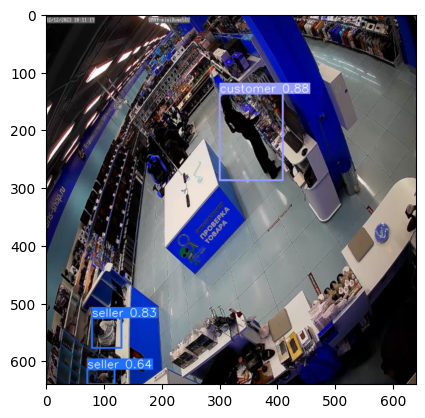

In [287]:
plt.imshow(data["frame_show"])
plt.show()

In [288]:
data = yolo_detector_mock(data, imgs[1], 1)
data = intel_dpt_large_mock(data, 1, (640,640), "cuda:0", "Intel/dpt-large")
data = calculate_distance_mock(1, data)
data = structural_similarity_mock(1, data)
data = solo_customer_mock(
    1,
    data,
    threshold_time = 0,
    threshold_similarity = 0.5,
    threshold_distance = 400.0,
)
data = save_metadata_mock(data)
data = load_metadata_mock(data)


0: 640x640 1 customer, 2 sellers, 20.7ms
Speed: 1.3ms preprocess, 20.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)
1 depth estimation


/root/miniconda3/envs/ipynb/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


1 distance calculate
1 structural similarity
1 solo customer


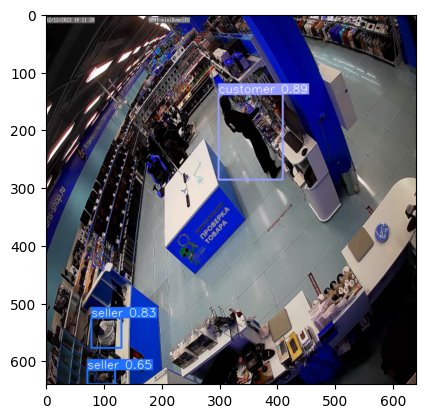

In [289]:
plt.imshow(data["frame_show"])
plt.show()

In [290]:
data["metadata"]["similarity"]

[{'uuid_people': '5bea1170-a7c1-45dd-aae9-7c2b49e3db4d',
  'uuid_prev_people': '4b1c8964-0a61-486d-89d6-d6e3b8fb85a5',
  'value': 0.6029334336074146},
 {'uuid_people': '5bea1170-a7c1-45dd-aae9-7c2b49e3db4d',
  'uuid_prev_people': '22d3c23d-176e-42bb-a268-b175e206f381',
  'value': 0.06246588545933163},
 {'uuid_people': '5bea1170-a7c1-45dd-aae9-7c2b49e3db4d',
  'uuid_prev_people': '2ac7b73d-ae4e-4194-b64c-b4f9c1688349',
  'value': 0.06342491336956346},
 {'uuid_people': '5a32c9fb-47ba-4f6d-9cda-283ef611ed4c',
  'uuid_prev_people': '4b1c8964-0a61-486d-89d6-d6e3b8fb85a5',
  'value': 0.022036736549984462},
 {'uuid_people': '5a32c9fb-47ba-4f6d-9cda-283ef611ed4c',
  'uuid_prev_people': '22d3c23d-176e-42bb-a268-b175e206f381',
  'value': 0.8869225102937573},
 {'uuid_people': '5a32c9fb-47ba-4f6d-9cda-283ef611ed4c',
  'uuid_prev_people': '2ac7b73d-ae4e-4194-b64c-b4f9c1688349',
  'value': 0.06277927447875413},
 {'uuid_people': '0b1c03ef-fe87-40e6-81ff-881e720ab239',
  'uuid_prev_people': '4b1c8964-

In [291]:
data["metadata"]["solo_customers"]

{'5bea1170-a7c1-45dd-aae9-7c2b49e3db4d': datetime.datetime(2024, 6, 6, 12, 20, 12, 936882)}

In [292]:
data["metadata"].keys()

dict_keys(['frame_dpt', 'prev_peoples', 'similarity', 'solo_customers'])

In [293]:
data = yolo_detector_mock(data, imgs[1], 1)
data = intel_dpt_large_mock(data, 1, (640,640), "cuda:0", "Intel/dpt-large")
data = calculate_distance_mock(1, data)
data = structural_similarity_mock(1, data)
data = solo_customer_mock(
    1,
    data,
    threshold_time = 0,
    threshold_similarity = 0.5,
    threshold_distance = 400.0,
)


0: 640x640 1 customer, 2 sellers, 21.1ms
Speed: 1.0ms preprocess, 21.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
1 depth estimation


/root/miniconda3/envs/ipynb/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


1 distance calculate
1 structural similarity
1 solo customer
Присутствуют одинокие покупатели


In [295]:
data["metadata"]["solo_customers"]

{'5bea1170-a7c1-45dd-aae9-7c2b49e3db4d': datetime.datetime(2024, 6, 6, 12, 20, 12, 936882)}